In [1]:
import os
import plotly
import geojson
import imageio
import numpy as np
import pandas as pd
import networkx as nx
import plotly.plotly as py
import moviepy.editor as mp
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly import tools as tls
from itertools import groupby
from plotly.offline import iplot, init_notebook_mode

In [164]:
init_notebook_mode(connected=True)

mapbox_access_token = 'pk.eyJ1Ijoic2lsdmVyc2VlZCIsImEiOiJjam5pNmc3NzAwN3VkM3BsazM3cHRzcmRjIn0.3H4Qchxudkfs8D1PWxLUvA'
plotly.tools.set_credentials_file(username = 'fansantos', api_key = 'I9HKCsAXlgB1hEMlqcYG')
#Danillo: username = 'dbsdmat', api_key='lhTPNNiRf2Ala96MNKp3'
#Everlon: username = 'GoldSeed', api_key = '1cuptk54PTYZG8SnX1W2'
#Fernando: username = 'fansantos', api_key = 'I9HKCsAXlgB1hEMlqcYG'

In [165]:
def Casos(arq,semana):
    """Lê o arquivo do ano com informação dos casos epidêmicos e semana de ocorrência. Retorna um Dataframe com as informações de ocorrêcias por bairro."""
    tabela_oficial=pd.read_csv('lat e long recife.csv' ,sep='\t',parse_dates = True, na_values = 0, encoding='latin-1',low_memory=False).rename(index=str, columns={"co_bairro_residencia": "codigo", "no_bairro_residencia": "bairro","lat":"latitude","long":"longitude"})
    T=pd.read_csv(arq, parse_dates = True, na_values = 0, encoding='latin-1',low_memory=False)
    L=T[T['semana']==semana]
    bairro=list(L['bairro'])
    #data=dict([(i, bairro.count(i)) for i in tabela_oficial['bairro']])
    #Funciona da mesma forma que:
    data={}
    for i in tabela_oficial['bairro'].map(lambda x: x.strip()):
        data[i]=[bairro.count(i)]
    return pd.DataFrame(data)  

def correlation_matrix(arq,t0,t1,e=2,absolute=True):
    """Recebe informações de ano(s), semana inicial e final, valor de Euler (por padrão igual a 2) e método (por padrão, absoluto). Se absolute=False, considera-se apenas valores de correlação maior que 0, se 'original', retorna-se as correlações positivas, nulas e negativas."""
    C=Casos(arq,t0)
    for i in range(t0,t1):
        C.loc[i]=Casos(arq,i+1).loc[0]
    if absolute=='original':
        matrix=np.array(C.corr().fillna(0))
        filter_matrix=[[0 if matrix[i,j]<1-e else matrix[i,j] for i in range(0,94)] for j in range(0,94)] 
    else:
        if absolute==True:
            matrix=np.absolute(np.array(C.corr().fillna(0)))
            filter_matrix=[[0 if matrix[i,j]<1-e else matrix[i,j] for i in range(0,94)] for j in range(0,94)]
        else:
            matrix=np.array(C.corr().fillna(0))
            M=np.array([[0 if matrix[i,j]<0 else matrix[i,j] for i in range(0,94)] for j in range(0,94)])
            filter_matrix=[[0 if M[i,j]<1-e else M[i,j] for i in range(0,94)] for j in range(0,94)]
  
    return pd.DataFrame(filter_matrix)

def graph_from_matrix(arq,t0,t1,e,absolute=True,p=False):
    """Retorna o gráfico a partir da função de correlação correlation_matrix. Por padrão, o gráfico não é desenhado (p=False)."""
    tabela=pd.read_csv('lat e long recife.csv' ,sep='\t',parse_dates = True, na_values = 0, encoding='latin-1',low_memory=False).rename(index=str, columns={"co_bairro_residencia": "codigo", "no_bairro_residencia": "bairro","lat":"latitude","long":"longitude"})
    #tabela=pd.read_csv('Tabela_Oficial_2014.csv',na_values=0)
    tabela.fillna(0)
    Graph=nx.from_numpy_matrix(np.array(correlation_matrix(arq,t0,t1,e,absolute)))
    mapping={i:i+1 for i in range(0,94)}
    H=nx.relabel_nodes(Graph, mapping)
    for i in range(0,94):
        H.add_node(i+1, pos=(tabela['longitude'][i], tabela['latitude'][i]))
        H.node[i+1]['codigo']=tabela['codigo'][i]
        H.node[i+1]['bairro']=tabela['bairro'][i]
        H.node[i+1]['latitude']=tabela['latitude'][i]
        H.node[i+1]['longitude']=tabela['longitude'][i]
    H.nodes(data=True)  
    #Graph=nx.from_numpy_matrix(np.array(correlation_matrix(arq,t0,t1,e)))
    #nx.draw(Graph, nx.get_node_attributes(F, 'pos'), with_labels=True, node_size=200)
    if p==True:
        nx.draw(H, nx.get_node_attributes(H, 'pos'), with_labels=True, node_size=200)
        plt.show()
    return H
#graph_from_matrix('2015.csv',1,52,0.2,'original',True)

In [166]:
def plotly_graph(arq ,t0 ,t1 ,e ,absolute = True ,user = 'GoldSeed' ,api = '1cuptk54PTYZG8SnX1W2'):
    """Gera o gráfico do pacote plotly a partir do gráfico gerado por graph_from_matrix. Lembre-se que você precisará criar uma conta no Plotly e exibir seu login e api_key para esta função."""
   
    G=graph_from_matrix(arq,t0,t1,e,absolute)
    
    mapbox_access_token = 'pk.eyJ1Ijoic2lsdmVyc2VlZCIsImEiOiJjam5pNmc3NzAwN3VkM3BsazM3cHRzcmRjIn0.3H4Qchxudkfs8D1PWxLUvA'
    geojson = 'https://raw.githubusercontent.com/AntonioMarcossj/Aedis-Networks/Tabalas-oficiais/Fronteira%20dos%20Bairros.json'
    plotly.tools.set_credentials_file(username = user, api_key = api)
    #Danillo: username = 'dbsdmat', api_key='lhTPNNiRf2Ala96MNKp3'
    #Everlon: username = 'GoldSeed', api_key = '1cuptk54PTYZG8SnX1W2'
    #Fernando: username = 'fansantos', api_key = 'I9HKCsAXlgB1hEMlqcYG'
    
    df=pd.read_csv('https://raw.githubusercontent.com/AntonioMarcossj/Aedis-Networks/Dengue/Dados%20de%20Recife/Tabela_de_Bairros.csv' ,sep=',',parse_dates = True, na_values = 0, encoding='latin-1',low_memory=False).rename(index=str, columns={"co_bairro_residencia": "codigo", "no_bairro_residencia": "bairro","lat":"latitude","long":"longitude"})
    df = df.fillna(0)
    Title = 'Grafo de '+str(arq[:-4])+'         Semanas de '+str(t0)+' a '+str(t1)+'         Parâmetro e = '+str(e)
    
    edge_trace = dict(
        type='scattermapbox',
        lon=[],
        lat=[],
        mode='lines',
        line=dict(width=1.5,color='crimson'), 
        opacity = 0.3,
        hoverinfo='none')

    for edge in G.edges():
        x0, y0 = G.node[edge[0]]['pos']
        x1, y1 = G.node[edge[1]]['pos']
        edge_trace['lon'] += tuple([x0, x1, None])
        edge_trace['lat'] += tuple([y0, y1, None])

        
    node_trace = dict(
        type='scattermapbox',
        lon=[],
        lat=[],
        text=[str(i) for i in df['codigo']],
        mode='markers+text',
        #hoverinfo='text',
        marker=dict(
            opacity = 0.9,
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='Electric',
            reversescale=True,
            color=[G.degree(i) for i in range(1,len(G.degree)+1)],
            cmin = 0,
            cmax = 94,
            size= 20,
            colorbar=dict(
                tickangle = -90,
                thickness = 25,
                title = 'Quantidade de Arestas',
                titleside = 'right',
                titlefont = dict(size = 20),
                tickfont = dict(size = 16)
            )
        )
    )

    for node in G.nodes():
        x, y = G.node[node]['pos']
        node_trace['lon'] += tuple([x])
        node_trace['lat'] += tuple([y])
        
    
    node_size_trace = dict(
        type='scattermapbox',
        subplot='mapbox2',
        lon=[],
        lat=[],
        text=[str(i) for i in df['codigo']],
        mode='markers+text',
        marker=dict(
            opacity = 0.9,
            showscale=False,
            colorscale='Electric',
            reversescale=True,
            color=[G.degree(i) for i in range(1,len(G.degree)+1)],
            cmin = 0,
            cmax = 94,
            size= [G.degree(i) for i in range(1,len(G.degree)+1)], 
            #colorbar=dict(
            #    tickangle = -90,
            #    thickness = 25,
            #    title = 'Quantidade de Arestas',
            #    titleside = 'right',
            #    titlefont = dict(size = 30),
            #    tickfont = dict(size = 25)
            #)
        )
    )
    
    for node in G.nodes():
        x, y = G.node[node]['pos']
        node_size_trace['lon'] += tuple([x])
        node_size_trace['lat'] += tuple([y])
    
    
    Layout = dict(
            title = Title,
            titlefont = dict(size = 30),
            autosize = False,
            showlegend=False,                     
            mapbox=dict(
                domain = dict( x = [0,0.495], y=[0,1]),
                layers=[
                    dict(
                        sourcetype = 'geojson',
                        source = geojson,
                        type = 'line',
                        line=dict(width=2),
                        opacity = 0.5,
                        color = 'gray'
                    )
                ],
                accesstoken=mapbox_access_token,
                center=dict(
                    lat=-8.04,
                    lon=-34.937
                ),
                 zoom = 11
            ),
            
            mapbox2=dict(
                domain = dict( x = [0.505,1], y=[0,1]),
                layers=[
                    dict(
                        sourcetype = 'geojson',
                        source = geojson,
                        type = 'line',
                        line=dict(width=2),
                        opacity = 0.5,
                        color = 'gray'
                    )
                ],
                accesstoken=mapbox_access_token,
                center=dict(
                    lat=-8.04,
                    lon=-34.937
                ),
             zoom = 11
            )
    )
                     
    

    fig = go.Figure(data=[edge_trace, node_trace, node_size_trace], layout = Layout)     
    

    
    
    return fig


In [167]:
fig = plotly_graph('2013.csv' ,1 ,52 , 0.5)

In [168]:
iplot(fig)

In [267]:
py.image.save_as(fig, 'hhhhh.png', width = 1350, height = 900, scale=1.1)

In [262]:
df=pd.read_csv(
    'https://raw.githubusercontent.com/AntonioMarcossj/Aedis-Networks/Dengue/Dados%20de%20Recife/Tabela_de_Bairros.csv',
    sep=',',
    parse_dates = True, 
    na_values = 0, 
    encoding='latin-1',
    low_memory=False
)
df = df.fillna(0)

mapbox_access_token = 'pk.eyJ1Ijoic2lsdmVyc2VlZCIsImEiOiJjam5pNmc3NzAwN3VkM3BsazM3cHRzcmRjIn0.3H4Qchxudkfs8D1PWxLUvA'
geojson = 'https://raw.githubusercontent.com/AntonioMarcossj/Aedis-Networks/Tabalas-oficiais/Fronteira%20dos%20Bairros.json'
plotly.tools.set_credentials_file(username = 'GoldSeed', api_key = '1cuptk54PTYZG8SnX1W2')

data_df = go.Table(
    domain = dict(x=[0,0.15], y=[0,1]),
    columnwidth = [25] + [60],
    header = dict(
        values = ['Código','Bairro'],
        height = 25,
        line = dict(color='rgb(50, 50, 50)'),
        font = dict(color=['rgb(45, 45, 45)'] , size=14),
        fill = dict(color='Cyan')
    ),
    cells = dict(
        values = [[str(i) for i in df['codigo']],df['bairro']],
        line = dict(color='#506784'),
        font = dict(color=['rgb(40, 40, 40)'], size=10),
        height = 18,
        fill = dict(color=['lightblue'])
    )
)

data_map = go.Scattermapbox(
        mode = 'markers+text',
        lat=df['Latitude'],
        lon=df['Longitude'],
        text = [str(i) for i in df['codigo']],
        marker = dict(
            color = 'white',
            size=20,
            opacity=1
        )
       )
    

layout = go.Layout(
    title = 'Mapa ',
    width = 1600,
    height = 1900,
    mapbox=dict(
        domain = dict(x=[0.16,1], y=[0,1]),
        layers=[
            dict(
                sourcetype = 'geojson',
                source = geojson,
                 type = 'line',
                opacity = 0.8,
                color = 'gray',
                line=dict(width=3)
            )
        ],
        accesstoken=mapbox_access_token,
        center=dict(
             lat=-8.043,
            lon=-34.937
        ),
         zoom = 12.3
    )
)
        

Fig = dict( data = [data_df, data_map], layout = layout)
iplot(Fig)

In [266]:
py.image.save_as(Fig, 'hhh.png', width = 1600, height = 1900, scale=2)

In [274]:
a0=df['Longitude'][0]

In [275]:
a1=df['Longitude'][1]

In [276]:
b0=df['Latitude'][0]

In [277]:
b1=df['Latitude'][1]

In [314]:
H=[[((((df['Longitude'][i]-df['Longitude'][j])**(2))+((df['Latitude'][i]-df['Latitude'][j])**2))**(1/2)) 
    for i in range(94)] for j in range(94)]

In [ ]:
df=pd.read_csv(
    'https://raw.githubusercontent.com/AntonioMarcossj/Aedis-Networks/Dengue/Dados%20de%20Recife/Tabela_de_Bairros.csv',
    sep=',',
    parse_dates = True, 
    na_values = 0, 
    encoding='latin-1',
    low_memory=False
)
df = df.fillna(0)

H=[[((((df['Longitude'][i]-df['Longitude'][j])**(2))+((df['Latitude'][i]-df['Latitude'][j])**2))**(1/2)) 
    for i in range(94)] for j in range(94)]

H = pd.DataFrame(np.array(H))

In [315]:
H = pd.DataFrame(np.array(H))

In [317]:
H.to_csv('Distancias.csv')

In [318]:
H

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,0.000000,0.014460,0.022529,0.030784,0.034727,0.023190,0.026438,0.024570,0.029721,0.010988,...,0.072234,0.077203,0.092666,0.105773,0.096240,0.094590,0.101043,0.102912,0.033211,0.053090
1,0.014460,0.000000,0.008219,0.017406,0.020272,0.009492,0.014469,0.017558,0.018683,0.018803,...,0.058491,0.064912,0.079468,0.091657,0.083688,0.082405,0.089244,0.090804,0.037686,0.055973
2,0.022529,0.008219,0.000000,0.012813,0.012566,0.006653,0.012806,0.019895,0.017187,0.026606,...,0.051878,0.059814,0.073355,0.084433,0.078191,0.077256,0.084394,0.085673,0.043674,0.060800
3,0.030784,0.017406,0.012813,0.000000,0.009533,0.007916,0.005726,0.014813,0.007276,0.030423,...,0.041451,0.047593,0.062113,0.075142,0.066295,0.065086,0.072039,0.073496,0.041178,0.055290
4,0.034727,0.020272,0.012566,0.009533,0.000000,0.012644,0.014544,0.023936,0.016808,0.036980,...,0.039730,0.049148,0.061521,0.071897,0.066919,0.066357,0.073772,0.074738,0.050202,0.064805
5,0.023190,0.009492,0.006653,0.007916,0.012644,0.000000,0.006214,0.013665,0.010657,0.024349,...,0.049152,0.055469,0.069996,0.082582,0.074206,0.072964,0.079863,0.081370,0.038742,0.054997
6,0.026438,0.014469,0.012806,0.005726,0.014544,0.006214,0.000000,0.009393,0.004461,0.024980,...,0.046172,0.050910,0.066244,0.080140,0.069873,0.068365,0.075037,0.076732,0.035695,0.050560
7,0.024570,0.017558,0.019895,0.014813,0.023936,0.013665,0.009393,0.000000,0.008597,0.019334,...,0.051988,0.054000,0.070604,0.086245,0.073132,0.071088,0.077167,0.079281,0.026367,0.041430
8,0.029721,0.018683,0.017187,0.007276,0.016808,0.010657,0.004461,0.008597,0.000000,0.026818,...,0.043966,0.047495,0.063360,0.078155,0.066562,0.064869,0.071371,0.073195,0.034552,0.048048
9,0.010988,0.018803,0.026606,0.030423,0.036980,0.024349,0.024980,0.019334,0.026818,0.000000,...,0.070777,0.073320,0.089889,0.104929,0.092449,0.090339,0.096268,0.098484,0.022235,0.042102


In [327]:
import seaborn as sns

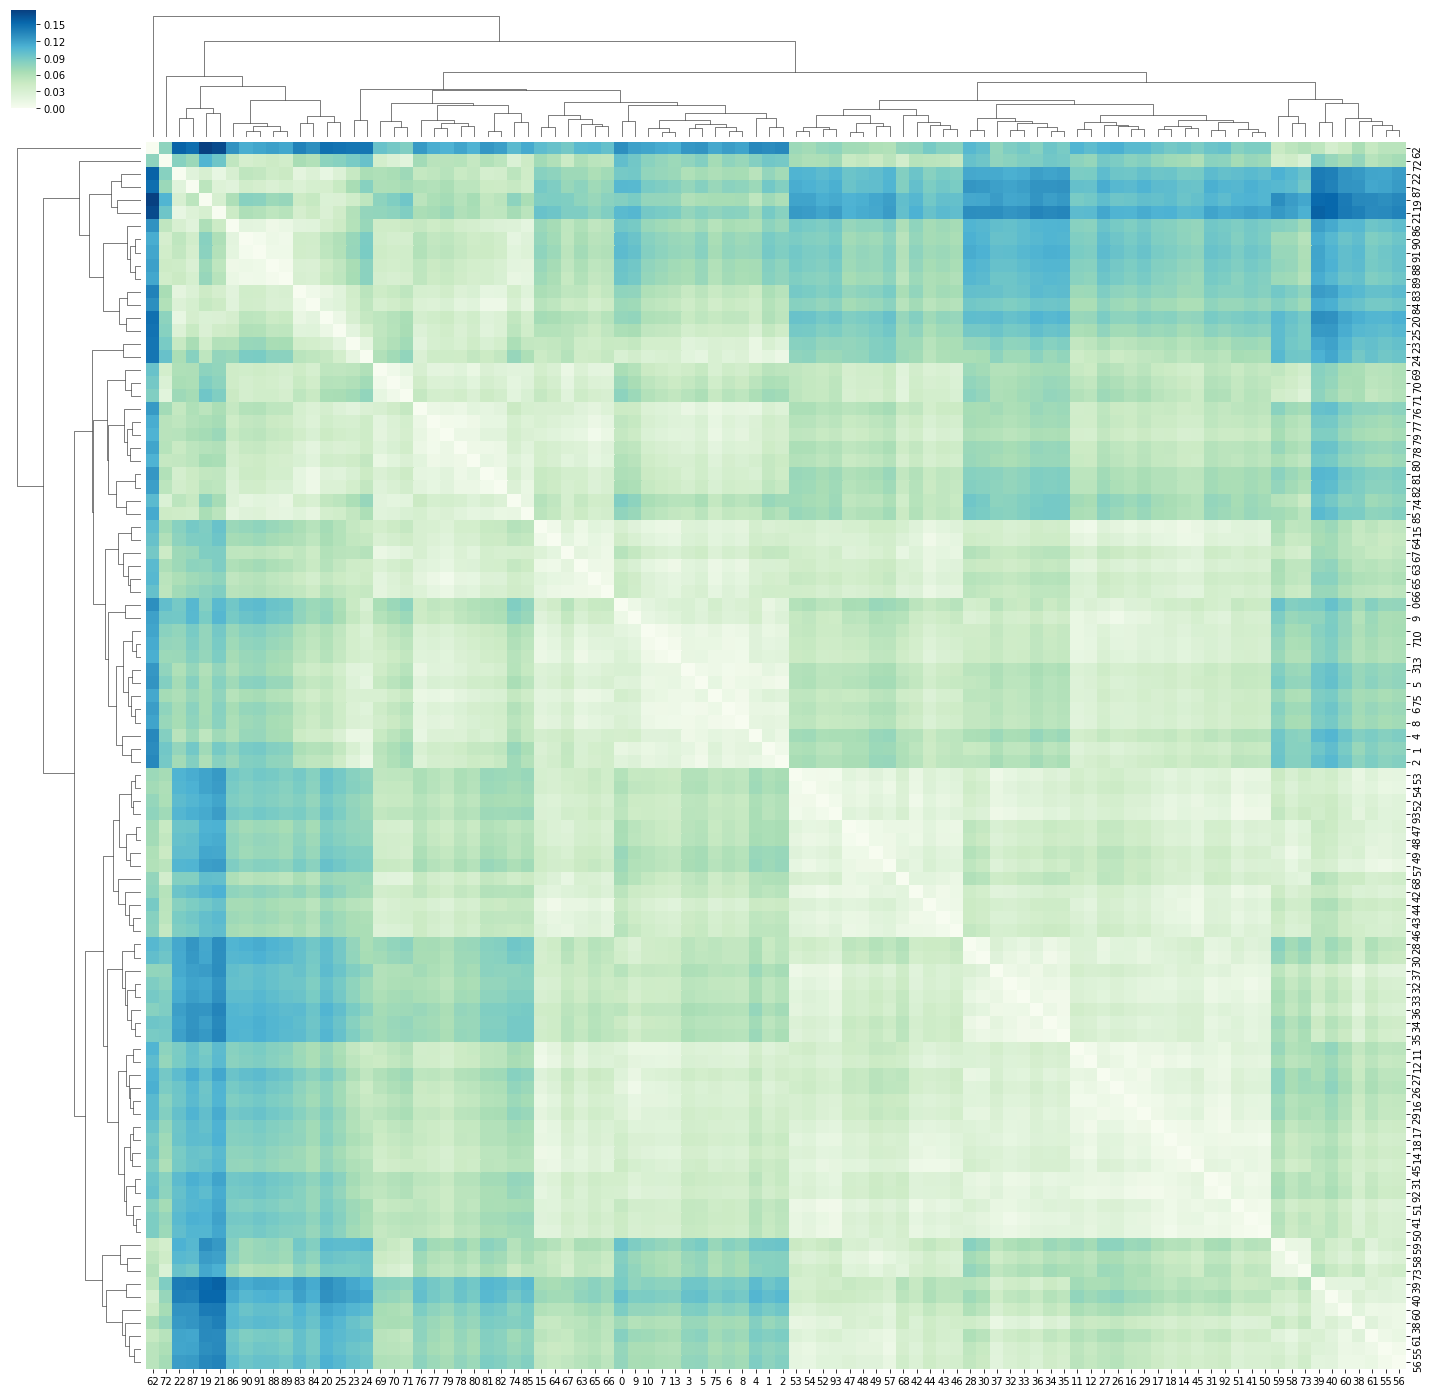

In [335]:
sns.clustermap(H, cmap='GnBu',  vmin=0 , linewidths=0, xticklabels=True, yticklabels=True, figsize=(25,25))
plt.show()

In [344]:
py.image.save_as(dict(data=[DETA]), 'hahahahah.png', width = 1600, height = 1600, scale=2)